# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great flavor low in calories high in nutrients high in protein Usually protein powders are high priced and high in calories this one is a great bargain and tastes great I highly recommend for the lady gym rats probably not macho enough for guys since it is soy based 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 46071/46071 [00:20<00:00, 2207.36it/s]


In [23]:
preprocessed_reviews[1500]

'great flavor low calories high nutrients high protein usually protein powders high priced high calories one great bargain tastes great highly recommend lady gym rats probably not macho enough guys since soy based'

# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


# [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


# [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2V

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2V

In [ ]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


# Obtaining the Required DataFrame:

In [24]:
type(preprocessed_reviews)

list

In [25]:
print(final.shape)

(46071, 10)


We obtain a list at the end of all the Preprocessing whereas the data frame that we obtained at the end was named 
'final'. Initially I considered 50K datapoints to work upon which got reduced to approx. 46K datapoints after all 
the text processing and data deduplication.

Out of these 46K datapoints in total we will consider only 25K points to be applied to the Random Forest & XGBoost Algorithms.

In [26]:
final['Preprocessed_Reviews'] = preprocessed_reviews

Basically I have taken the entire list and added the list as a column to the entire dataframe, such that each value
corresponds to a row in the dataframe. 

In [27]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Preprocessed_Reviews
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...,product available victor traps unreal course t...
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...,used victor fly bait seasons ca not beat great...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,received shipment could hardly wait try produc...


Now I have a total of approx. 46K rows in the dataframe called 'final', of which I will consider only 25K rows to
be applied to the Random Forest Classifier & the XGBoost Algorithms. Also here you have the Unix Timestamp in the data, which is basically the time when the review was posted. 

This makes it possible to carry out Time Based Split of the data instead of random splitting of the data into Train,
CV and Test Datasets. For Time Based Split I will take the oldest of the reviews as the Training Data, the 
intermediate reviews as the CV data and the latest reviews as the Test data. 

In [28]:
final_TBS = final.sort_values('Time')

In [29]:
final_TBS.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Preprocessed_Reviews
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...,really good idea final product outstanding use...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,received shipment could hardly wait try produc...
28086,30629,B00008RCMI,A19E94CF5O1LY7,Andrew Arnold,0,0,1,1067040000,"I've chewed this gum many times, but used?","Nothing against the product, but it does bothe...",nothing product bother link top page buy used ...
28087,30630,B00008RCMI,A284C7M23F0APC,A. Mendoza,0,0,1,1067040000,Best sugarless gum ever!,I love this stuff. It is sugar-free so it does...,love stuff sugar free not rot gums tastes good...
38740,42069,B0000EIEQU,A1YMJX4YWCE6P4,"Jim Carson ""http://www.jimcarson.com""",12,12,1,1067558400,These limes rule!,"Fresh limes are underappreciated, but a joy to...",fresh limes underappreciated joy kitchen squir...


Now the values are sorted on the basis of Time. We know that by default the values are sorted in ascending order. 

# Further Data Processing :- 

First I will remove all the useless columns from my dataframe. The only columns that we are concerned about here in 
this case are the 'Score' & 'Preprocessed_Reviews' (Without carrying out any Feature Engineering). Remaining columns 
in the dataframe are of no use to us. 

In [30]:
df = final_TBS[['Score','Preprocessed_Reviews']]

In [31]:
df.head()

,Score,Preprocessed_Reviews
1146,1,really good idea final product outstanding use...
1145,1,received shipment could hardly wait try produc...
28086,1,nothing product bother link top page buy used ...
28087,1,love stuff sugar free not rot gums tastes good...
38740,1,fresh limes underappreciated joy kitchen squir...


# [5.1] Applying Random Forest Classification :-

# Obtaining Train, CV and Test Data :-

In [32]:
RF_df = df[:25000]

Basically we are taking a total of 25K reviews for the model. Since I am carrying out Time Based Splitting into 
Train, CV and Test datasets, I will split them in 70:10:20 ratio respectively. 
        
        So, # of Datapoints in Train data = 17500
            # of Datapoints in CV data = 2500
            # of Datapoints in Test data = 5000

In [33]:
Tr_RF_df = RF_df[:17500]
CV_RF_df = RF_df[17500:20000]
Te_RF_df = RF_df[20000:25000]

In [34]:
Tr_RF_df.shape

(17500, 2)

In [35]:
CV_RF_df.shape

(2500, 2)

In [36]:
Te_RF_df.shape

(5000, 2)

Yes everything is working as expected: There are 17,500 points in the Training data, 2500 points in the CV data and 5K points in the Test data.

Now we can split the data as features in X and the class label in Y.

In [39]:
X_RFTrain = Tr_RF_df['Preprocessed_Reviews']
Y_RFTrain = Tr_RF_df['Score']

X_RFCV = CV_RF_df['Preprocessed_Reviews']
Y_RFCV = CV_RF_df['Score']

X_RFTest = Te_RF_df['Preprocessed_Reviews']
Y_RFTest = Te_RF_df['Score']

In [45]:
Y_RFTrain.value_counts()

1    15008
0     2492
Name: Score, dtype: int64

In [46]:
Y_RFCV.value_counts()

1    2074
0     426
Name: Score, dtype: int64

In [47]:
Y_RFTest.value_counts()

1    4145
0     855
Name: Score, dtype: int64

As expected, this is an imbalanced real world dataset. 

# [5.1.1] SET 1 : Applying Random Forest on BOW :-

In [48]:
count_vect = CountVectorizer()
count_vect.fit(X_RFTrain) #Again the fit function is applied only on the Train data. 

#fit internally stores the parameters that will be used for transforming the data from the text to a numerical vector

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [50]:
X_RFTrain_BOW = count_vect.transform(X_RFTrain)
X_RFCV_BOW = count_vect.transform(X_RFCV)
X_RFTest_BOW = count_vect.transform(X_RFTest)

In [51]:
print("Shapes before the BOW Vectorization was carried out:")

print(X_RFTrain.shape,Y_RFTrain.shape)
print(X_RFCV.shape,Y_RFCV.shape)
print(X_RFTest.shape,Y_RFTest.shape)

print("*"*100)

print("Shapes after the BOW Vectorization was carried out:")

print(X_RFTrain_BOW.shape,Y_RFTrain.shape)
print(X_RFCV_BOW.shape,Y_RFCV.shape)
print(X_RFTest_BOW.shape,Y_RFTest.shape)

Shapes before the BOW Vectorization was carried out:
(17500,) (17500,)
(2500,) (2500,)
(5000,) (5000,)
****************************************************************************************************
Shapes after the BOW Vectorization was carried out:
(17500, 25012) (17500,)
(2500, 25012) (2500,)
(5000, 25012) (5000,)


# Hyperparameter Tuning on the BOW Representation :- 

Here we care about 2 hyperparameters :-
* "max_depth", which we would be considering in the range :- { [4,6,8,9,10,12,14,17] }
* "n_estimators", which we would be considering in the range of (500,1200) in the interval of 100 and see how which value is ideal in our scenario.

According to "https://stackoverflow.com/questions/36107820/how-to-tune-parameters-in-random-forest-using-scikit-learn", the more the number of estimators or base learners present in the Random Forest the better it is and a value in the range of (500,1000) usually suffices in most scenarios.

I am basically considering the same Hyperparameter values as the ones that I tried for max_depth when we carried out Hyperparameter Tuning for Decision Trees. However, this is not the case for n_estimators. 

We can easily apply GridSearchCV in this case since we are only focused on 2 Hyperparameters. If we had to obtain the best values for a lot of hyperparameters, GridSearchCV won't have been the best option considering its
time complexity.

In [52]:
depth_hyperparameter = [4,6,8,9,10,12,14,17]
estimators_hyperparameter = []

for i in range(500,1300,100):
    estimators_hyperparameter.append(i)

print("The number of Estimators(Base Learners) for the Random Forest Classification are considered in the following "
      "range:")
print(estimators_hyperparameter)

The number of Estimators(Base Learners) for the Random Forest Classification are considered in the following range:
[500, 600, 700, 800, 900, 1000, 1100, 1200]


Here we have generated a list with the required values of the 2 hyperparameters. The necessary 
packages are imported as follows:- 

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np
import warnings

Again, the important fact to be noticed for the Random Forest Clasifier is the fact that Random Forests are made up of Decision Trees (of large depth) as the base learners and since for Decision Trees there was no need to carry out Standardization because we did not have any hyperplane in consideration, there is no need to carry out Standardization for Random Forests as well. 

<b> <font color="black"> Function to obtain the DataFrame for the AUC Metric Calculation from the Training Data  :- </font> </b>

In [54]:
def RFTrain_Heatmap(X_Train,Y_Train):

    df1 = []
    df2 = []
    Train_AUC = []

    for i in depth_hyperparameter:
        for j in estimators_hyperparameter:
            df1.append(i)
            df2.append(j)
        
            Train_model = RandomForestClassifier(n_estimators=j,criterion='gini',max_depth=i,min_samples_split=2,
                                                 bootstrap=True,n_jobs=-1,class_weight='balanced',random_state=0)
            Train_model.fit(X_Train,Y_Train)
        
            Y_Train_pred = Train_model.predict_proba(X_Train)[:,1]
            Train_AUC.append(roc_auc_score(Y_Train,Y_Train_pred))  
            
    train_data = {'max_depth':df1,'n_estimators':df2,'AUC_Score':Train_AUC}
    train_dataframe = pd.DataFrame(train_data)
    train_dataframe = train_dataframe.pivot("max_depth","n_estimators","AUC_Score")
            
    return train_dataframe            

Ideally speaking, the larger is the value of max_depth for Random Forests the better it is, because our job is to obtain our Base Learners (Decision Trees) with a high variance, which is achievable by a deep Decision Tree.

<b> <font color="black"> Function to obtain the DataFrame for the AUC Metric Calculation from the CV Data  :- </font> </b>

In [55]:
def RFCV_Heatmap(X_Train,Y_Train,X_CV,Y_CV):

    df3 = []
    df4 = []
    CV_AUC = []

    for i in depth_hyperparameter:
        for j in estimators_hyperparameter:
            df3.append(i)
            df4.append(j)
        
            CV_model = RandomForestClassifier(n_estimators=j,criterion='gini',max_depth=i,min_samples_split=2,
                                              bootstrap=True,n_jobs=-1,class_weight='balanced',random_state=0)
            CV_model.fit(X_Train,Y_Train)
        
            Y_CV_pred = CV_model.predict_proba(X_CV)[:,1]
            CV_AUC.append(roc_auc_score(Y_CV,Y_CV_pred))  
            
    cv_data = {'max_depth':df3,'n_estimators':df4,'AUC_Score':CV_AUC}
    cv_dataframe = pd.DataFrame(cv_data)
    cv_dataframe = cv_dataframe.pivot("max_depth","n_estimators","AUC_Score")
            
    return cv_dataframe            

  What I have carried out in both of these functions is as follows :-
* We have already initialized 2 Lists for each of the 2 Hyperparameters :- "depth_hyperparameter" for the parameter "max_depth" and "estimators_hyperparameter" for the parameter "n_estimators" in the Random Forest Classifier. 
* Now basically we are trying to obtain a dataframe with all the possible combinations of the 2 Hyperparameters to obtain the corresponding Heatmap with the AUC Scores for that particular combination shown as an annotation in the Heatmap.
* Remember that even in the case to obtain the Cross Validation DataFrame, we are supposed to fit() only on the Train dataset. We give column headers to each of the columns in the DataFrame which we consequently pivot to obtain the data in the dataframe in the required format so that the Heatmap is plotted as expected. 
* Basically, at the end of calling each of these functions, we obtain the corresponding dataframe, whether that be for the Training Data or the CV Data. 

<b> <font color="black"> Function to plot the Seaborn HeatMaps for the Train & CV Dataframes obtained  :- </font> </b>

In [56]:
def rf_plotheatmaps(train_df,cv_df):
    fig, ax = plt.subplots(figsize=(30,5))

    plt.subplot(1, 3, 1)
    sns.heatmap(train_df, annot=True,cmap='RdYlGn',linewidths=0.5,annot_kws={"size": 13})
    plt.xlabel('n_estimators',fontsize=12)
    plt.ylabel('Max_Depth',fontsize=12)
    plt.title("Training Data AUC Score Heatmap",fontsize=15)

    plt.subplot(1, 3, 2)
    sns.heatmap(cv_df, annot=True,cmap='RdYlGn',linewidths=0.5,annot_kws={"size": 13})
    plt.xlabel('n_estimators',fontsize=12)
    plt.ylabel('Max_Depth',fontsize=12)
    plt.title("CV Data AUC Score Heatmap",fontsize=15)

    plt.show()

* In the function above, we are plotting the Seaborn HeatMaps for the Train and CV Dataframes next to each other as subplots for easier comparison of the AUC Values. 
* Note that we could have carried out the same with the help of a 3-D plot of the 2 Hyperparameters. However, the issue with this approach is the fact that it becomes difficult to visualise the right combination of the 2 Hyperparameters. 

* Again, our aim in choosing the Best Hyperparameters is the same as before :
 The AUC Value on the CV Dataset be the maximum and the gap between the Train and CV AUC values be low, which we obtain with the help of the Heatmaps obtained below. The same is confirmed by carrying out the GridSearchCV with 3-fold Cross Validation and obtaining the best_estimator_.

<b> <font color="black"> Calling the Different Functions to obtain the Train and CV Dataframes and Obtaining the Seaborn HeatMaps for them :- </font> </b>

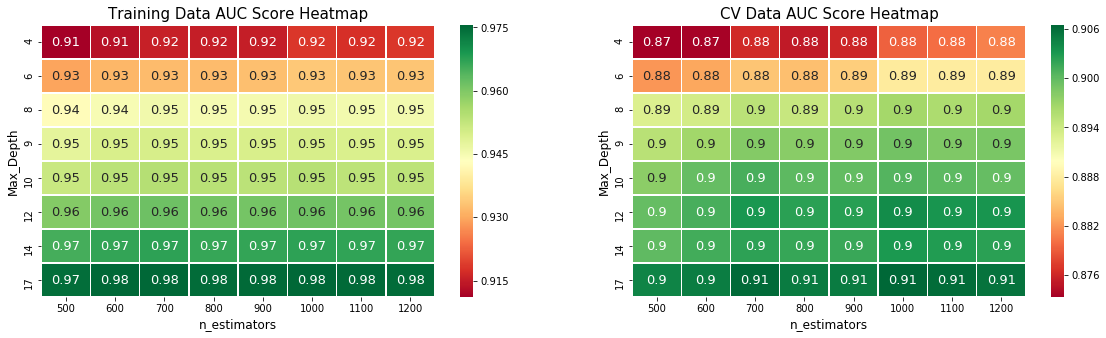

Time Consumed to Complete  Hyperparameter tuning for Simple CV Search for Random Forest Classifier on BOW Vectorizer (in minutes): 9.182292783260346


In [58]:
import time
start = time.time()

BOW_Train_df = RFTrain_Heatmap(X_RFTrain_BOW,Y_RFTrain)
BOW_CV_df = RFCV_Heatmap(X_RFTrain_BOW,Y_RFTrain,X_RFCV_BOW,Y_RFCV)
rf_plotheatmaps(BOW_Train_df,BOW_CV_df)

end = time.time()
print("Time Consumed to Complete  Hyperparameter tuning for Simple CV Search for Random Forest Classifier on "
      "BOW Vectorizer (in minutes):", (end - start)/60)

With the Seaborn Heatmaps obtained, we see that :
* The maximum AUC Value on the CV Heatmap is 0.90, and the minimum AUC Value on the Train Heatmap for the same combination is 0.95. 
* Therefore the Best Combination of Max_Depth and n_estimators for the BOW Featurization is either of the following: 

Max_Depth=9 or 10.
n_estimators= 1100 or 1200.

* Therefore the best of these values is obtained by GridSearchCV below.

In [59]:
warnings.filterwarnings('ignore')

#Carrying out 3-fold Cross Validation. class_weight is taken as 'balanced' since the data that we originally had
#was an Imbalanced Real World Dataset.

start = time.time()

parameters= [{'max_depth':depth_hyperparameter,'n_estimators':estimators_hyperparameter}]
model1 = RandomForestClassifier(criterion='gini',class_weight='balanced',min_samples_split=2,
                               bootstrap=True,n_jobs=-1)
    
RF_BOW = GridSearchCV(model1,parameters,scoring='roc_auc',cv=3)
RF_BOW.fit(X_RFTrain_BOW,Y_RFTrain)
    
print(RF_BOW.best_estimator_)

end = time.time()
print("Time Consumed to Complete  Hyperparameter tuning for GridSearchCV for Random Forest Classifier on "
      "BOW Vectorizer (in minutes):", (end - start)/60)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=12, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
Time Consumed to Complete  Hyperparameter tuning for GridSearchCV for Random Forest Classifier on BOW Vectorizer (in minutes): 38.91783331632614


Therefore obtaining the Best Hyperparameters of the model after carrying out Hyperparameter tuning via GridSearchCV, we obtain the following Best values :-
* max_depth = 12
* n_estimators = 1100

# Testing with the Test Data on the BOW Representation:-

In [163]:
RFBOW_Test = RandomForestClassifier(criterion='gini',class_weight='balanced',min_samples_split=2,max_depth=12,
                                  n_estimators=1100,bootstrap=True,n_jobs=-1)
RFBOW_Test.fit(X_RFTrain_BOW,Y_RFTrain)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=12, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

Therefore here we are basically creating a model (to Test the model on the Test Data) by applying the Best values of the Hyperparameters hence obtained.

In [61]:
Y_RFTrain.shape

(17500,)

In [62]:
print(X_RFTrain_BOW.shape)

(17500, 25012)


In [63]:
print(Y_RFTest.shape)

(5000,)


In [64]:
print(X_RFTest_BOW.shape)

(5000, 25012)


In [65]:
from sklearn.metrics import roc_curve, auc 

train_fpr1,train_tpr1,threshold = roc_curve(Y_RFTrain,RFBOW_Test.predict_proba(X_RFTrain_BOW)[:,1])
test_fpr1,test_tpr1,threshold = roc_curve(Y_RFTest,RFBOW_Test.predict_proba(X_RFTest_BOW)[:,1])

Plotting the graph between the FPR Values as well as the TPR values for the Training Data as well as the Test data
we obtain the ROC Curve as follows:

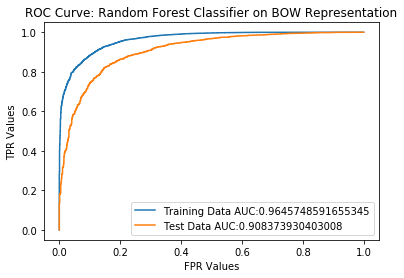

In [66]:
import matplotlib.pyplot as plt

plt.plot(train_fpr1,train_tpr1,label ='Training Data AUC:' + str(auc(train_fpr1,train_tpr1)))
plt.plot(test_fpr1,test_tpr1,label = 'Test Data AUC:' + str(auc(test_fpr1,test_tpr1)))
plt.legend()

plt.xlabel('FPR Values')
plt.ylabel('TPR Values')
plt.title('ROC Curve: Random Forest Classifier on BOW Representation')

plt.grid(False)
plt.show()

# [5.1.2] Top 20 Important Features with Random Forest Implementation & BOW Featurization :-

In [166]:
BOW_feature_names = count_vect.get_feature_names()
BOW_feature_importances = RFBOW_Test.feature_importances_
BOW_feature_importances_sorted = np.argsort(BOW_feature_importances)
BOW_feature_importances_reverse = np.flip(BOW_feature_importances_sorted)

In [167]:
print("The Top 20 Important Features with BOW Featurization and their corresponding feature " 
      "importances are as follows:")
print("="*100)
for i in BOW_feature_importances_reverse[:20]:
    print(BOW_feature_names[i],"\t", '--->',np.round(BOW_feature_importances[i],3))

The Top 20 Important Features with BOW Featurization and their corresponding feature importances are as follows:
not 	 ---> 0.037
great 	 ---> 0.022
best 	 ---> 0.015
would 	 ---> 0.015
perfect 	 ---> 0.014
love 	 ---> 0.013
horrible 	 ---> 0.012
delicious 	 ---> 0.012
disappointed 	 ---> 0.012
bad 	 ---> 0.011
money 	 ---> 0.011
worst 	 ---> 0.01
thought 	 ---> 0.008
highly 	 ---> 0.008
easy 	 ---> 0.008
wonderful 	 ---> 0.007
favorite 	 ---> 0.007
terrible 	 ---> 0.007
snack 	 ---> 0.007
product 	 ---> 0.007


# Wordcloud of Random Forest Implementation on BOW Featurization :-

As we have seen above, the first step of obtaining all the relevant features ie. the Top 20 Features is very straightforward and something that we have carried out in all of our Featurizations. Now the problem is that we need
to obtain the same in the form of a String so as to input it to a WordCloud as an attribute. Following are the steps carried out in order to achieve the same :

1. Input these 20 Most Important Words into a List.( This has been carried out in the code snippet below)
2. Now convert this List into a String with each word separated by a Whitespace. This is carried out by joining an empty string with the string that we have obtained. 
3. Now call the WordCloud with all its attributes defining on how we want the Word Cloud to be plotted.

In [224]:
from wordcloud import WordCloud

BOW_WC_Words = ' '
String_BOW_Words =[]
concat=''

j=0
while j <20:
    for i in BOW_feature_importances_reverse[0:j]:
        concat = BOW_WC_Words + BOW_feature_names[i]
    j=j+1
    String_BOW_Words.append(concat)    

In [226]:
print(String_BOW_Words[1:])

[' not', ' great', ' best', ' would', ' perfect', ' love', ' horrible', ' delicious', ' disappointed', ' bad', ' money', ' worst', ' thought', ' highly', ' easy', ' wonderful', ' favorite', ' terrible', ' snack']


In [227]:
Final_BOW = BOW_WC_Words.join(String_BOW_Words[1:])
print(Final_BOW)

 not  great  best  would  perfect  love  horrible  delicious  disappointed  bad  money  worst  thought  highly  easy  wonderful  favorite  terrible  snack


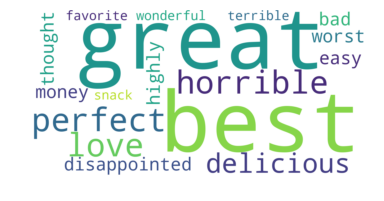

In [232]:
wordcloud_BOW = WordCloud(width = 1600, height = 800, 
                background_color ='white',  
                min_font_size = 10).generate(Final_BOW)

# Display the generated image:
plt.imshow(wordcloud_BOW, interpolation='bilinear')
plt.axis("off")
plt.show()

# [5.1.3] SET 2 : Applying Random Forest on TFIDF :-

In [73]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_RFTrain)

# Again fit is carried out only on the Training data. fit() internally stores the parameters that will be used to 
#convert the Text to a numerical vector. 

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=10,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [74]:
X_RFTrain_TFIDF = tf_idf_vect.transform(X_RFTrain)
X_RFCV_TFIDF = tf_idf_vect.transform(X_RFCV)
X_RFTest_TFIDF = tf_idf_vect.transform(X_RFTest)

In [75]:
print("Shapes before the TFIDF Vectorization was carried out:")

print(X_RFTrain.shape,Y_RFTrain.shape)
print(X_RFCV.shape,Y_RFCV.shape)
print(X_RFTest.shape,Y_RFTest.shape)

print("="*100)

print("Shapes after the TFIDF Vectorization was carried out:")

print(X_RFTrain_TFIDF.shape,Y_RFTrain.shape)
print(X_RFCV_TFIDF.shape,Y_RFCV.shape)
print(X_RFTest_TFIDF.shape,Y_RFTest.shape)

Shapes before the TFIDF Vectorization was carried out:
(17500,) (17500,)
(2500,) (2500,)
(5000,) (5000,)
Shapes after the TFIDF Vectorization was carried out:
(17500, 10508) (17500,)
(2500, 10508) (2500,)
(5000, 10508) (5000,)


# Hyperparameter Tuning on the TFIDF Representation :- 

Here we care about 2 hyperparameters :-
* "max_depth", which we would be considering in the range :- { [4,6,8,9,10,12,14,17] }
* "n_estimators", which we would be considering in the range of (500,1200) in the interval of 100 and see how which value is ideal in our scenario.

Again, the important fact to be noticed for the Random Forest Clasifier is the fact that Random Forests are made up of Decision Trees (of large depth) as the base learners and since for Decision Trees there was no need to carry out Standardization because we did not have any hyperplane in consideration, there is no need to carry out Standardization for Random Forests as well. 

<b> <font color="black"> Calling the Different Functions to obtain the Train and CV Dataframes and Obtaining the Seaborn HeatMaps for them :- </font> </b>

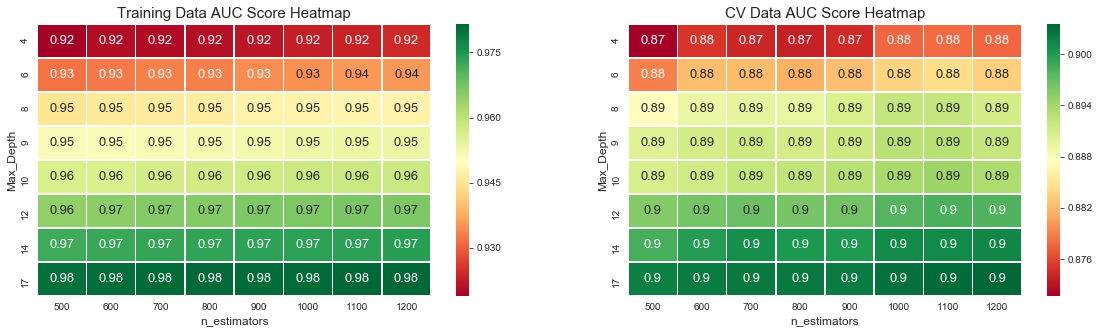

Time Consumed to Complete  Hyperparameter tuning for Simple CV Search for Random Forest Classifier on BOW Vectorizer (in minutes): 11.214406514167786


In [76]:
import time
start = time.time()

TFIDF_Train_df = RFTrain_Heatmap(X_RFTrain_TFIDF,Y_RFTrain)
TFIDF_CV_df = RFCV_Heatmap(X_RFTrain_TFIDF,Y_RFTrain,X_RFCV_TFIDF,Y_RFCV)
rf_plotheatmaps(TFIDF_Train_df,TFIDF_CV_df)

end = time.time()
print("Time Consumed to Complete  Hyperparameter tuning for Simple CV Search for Random Forest Classifier on "
      "BOW Vectorizer (in minutes):", (end - start)/60)

With the Seaborn Heatmaps obtained, we see that :
* The maximum AUC Value on the CV Heatmap is 0.90, and the minimum AUC Value on the Train Heatmap for the same combination is 0.97. 
* Therefore the Best Combination of Max_Depth and n_estimators for the TFIDF Featurization is either of the following: 

Max_Depth = 12 or 14.
n_estimators = 1100 or 1200.

* Therefore the best of these values is obtained by GridSearchCV below.

In [78]:
warnings.filterwarnings('ignore')

start = time.time()

#Carrying out 3-fold Cross Validation. class_weight is taken as 'balanced' since the data that we originally had
#was an Imbalanced Real World Dataset.

parameters= [{'max_depth':depth_hyperparameter,'n_estimators':estimators_hyperparameter}]
model2 = RandomForestClassifier(criterion='gini',class_weight='balanced',min_samples_split=2,
                               bootstrap=True,n_jobs=-1)
    
RF_TFIDF = GridSearchCV(model2,parameters,scoring='roc_auc',cv=3)
RF_TFIDF.fit(X_RFTrain_TFIDF,Y_RFTrain)
    
print(RF_TFIDF.best_estimator_)
print(" ")

end = time.time()
print("Time Consumed to Complete  Hyperparameter tuning for GridSearchCV for Random Forest Classifier on "
      "TFIDF Vectorizer (in minutes):", (end - start)/60)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=17, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
 
Time Consumed to Complete  Hyperparameter tuning for GridSearchCV for Random Forest Classifier on TFIDF Vectorizer (in minutes): 16.204486815134683


# Testing with the Test Data on the TFIDF Representation:-

In [79]:
RFTFIDF_Test = RandomForestClassifier(criterion='gini',class_weight='balanced',min_samples_split=2,max_depth=17,
                                  n_estimators=1100,bootstrap=True,n_jobs=-1)
RFTFIDF_Test.fit(X_RFTrain_TFIDF,Y_RFTrain)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=17, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

Therefore here we are basically creating a model (to Test the model on the Test Data) by applying the Best values of the Hyperparameters hence obtained.

In [80]:
Y_RFTrain.shape

(17500,)

In [81]:
print(X_RFTrain_TFIDF.shape)

(17500, 10508)


In [82]:
print(Y_RFTest.shape)

(5000,)


In [83]:
print(X_RFTest_TFIDF.shape)

(5000, 10508)


In [84]:
from sklearn.metrics import roc_curve, auc 

train_fpr2,train_tpr2,threshold = roc_curve(Y_RFTrain,RFTFIDF_Test.predict_proba(X_RFTrain_TFIDF)[:,1])
test_fpr2,test_tpr2,threshold = roc_curve(Y_RFTest,RFTFIDF_Test.predict_proba(X_RFTest_TFIDF)[:,1])

Plotting the graph between the FPR Values as well as the TPR values for the Training Data as well as the Test data
we obtain the ROC Curve as follows:

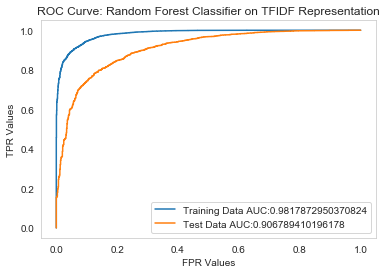

In [85]:
import matplotlib.pyplot as plt

plt.plot(train_fpr2,train_tpr2,label ='Training Data AUC:' + str(auc(train_fpr2,train_tpr2)))
plt.plot(test_fpr2,test_tpr2,label = 'Test Data AUC:' + str(auc(test_fpr2,test_tpr2)))
plt.legend()

plt.xlabel('FPR Values')
plt.ylabel('TPR Values')
plt.title('ROC Curve: Random Forest Classifier on TFIDF Representation')

plt.grid(False)
plt.show()

# [5.1.4] Top 20 Important Features with Random Forest Implementation & BOW Featurization :-

In [234]:
RFTFIDF_feature_names = tf_idf_vect.get_feature_names()
RFTFIDF_feature_importances = RFTFIDF_Test.feature_importances_
RFTFIDF_feature_importances_sorted = np.argsort(RFTFIDF_feature_importances)
RFTFIDF_feature_importances_reverse = np.flip(RFTFIDF_feature_importances_sorted)

In [240]:
print("The Top 20 Important Features with TFIDF Featurization and their corresponding feature importances" 
       "are as follows:")
print("="*100)

for i in RFTFIDF_feature_importances_reverse[:20]:
    print(RFTFIDF_feature_names[i],"\t", '--->',np.round(RFTFIDF_feature_importances[i],3))

The Top 20 Important Features with TFIDF Featurization and their corresponding feature importancesare as follows:
not 	 ---> 0.037
great 	 ---> 0.029
best 	 ---> 0.017
would 	 ---> 0.017
love 	 ---> 0.016
delicious 	 ---> 0.014
bad 	 ---> 0.013
disappointed 	 ---> 0.013
perfect 	 ---> 0.012
would not 	 ---> 0.011
worst 	 ---> 0.011
money 	 ---> 0.01
thought 	 ---> 0.009
good 	 ---> 0.009
not buy 	 ---> 0.009
favorite 	 ---> 0.008
loves 	 ---> 0.008
easy 	 ---> 0.008
horrible 	 ---> 0.008
away 	 ---> 0.007


# Wordcloud of Random Forest Implementation on TFIDF Featurization :-

In [236]:
from wordcloud import WordCloud

TFIDF_WC_Words = ' '
String_TFIDF_Words =[]
concat=''

j=0
while j <20:
    for i in RFTFIDF_feature_importances_reverse[0:j]:
        concat = TFIDF_WC_Words + RFTFIDF_feature_names[i]
    j=j+1
    String_TFIDF_Words.append(concat)    

In [237]:
print(String_TFIDF_Words[1:])

[' not', ' great', ' best', ' would', ' love', ' delicious', ' bad', ' disappointed', ' perfect', ' would not', ' worst', ' money', ' thought', ' good', ' not buy', ' favorite', ' loves', ' easy', ' horrible']


In [238]:
Final_TFIDF = TFIDF_WC_Words.join(String_TFIDF_Words[1:])
print(Final_TFIDF)

 not  great  best  would  love  delicious  bad  disappointed  perfect  would not  worst  money  thought  good  not buy  favorite  loves  easy  horrible


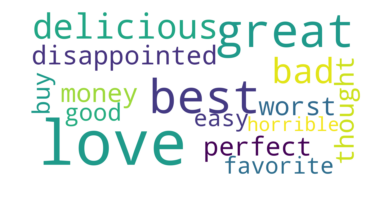

In [239]:
wordcloud_TFIDF = WordCloud(width = 1600, height = 800, 
                background_color ='white',  
                min_font_size = 10).generate(Final_TFIDF)

# Display the generated image:
plt.imshow(wordcloud_TFIDF, interpolation='bilinear')
plt.axis("off")
plt.show()

# [5.1.5] SET 3 : Applying Random Forest on Avg W2V :-

# Converting Reviews into Numerical Vectors using W2V vectors :-

In [93]:
list_of_sentence_Train =[]

for sentence in X_RFTrain:
    list_of_sentence_Train.append(sentence.split())

In [94]:
w2v_model=Word2Vec(list_of_sentence_Train,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("Number of words that occur a minimum 5 times :",len(w2v_words))
print("Some of the sample words are as follows: ", w2v_words[0:50])

Number of words that occur a minimum 5 times : 7984
Some of the sample words are as follows:  ['really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'bought', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'stickers', 'removed', 'easily', 'daughter', 'designed', 'signs', 'printed', 'reverse', 'windows', 'beautifully', 'print', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'nothing', 'bother', 'link', 'top', 'page', 'buy']


# Converting the Train Data Text :-

In [95]:
# average Word2Vec
# compute average word2vec for each review.

sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence_Train): # for each review/sentence for Training Dataset
    sent_vec = np.zeros(50) 
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|██████████| 17500/17500 [00:30<00:00, 564.83it/s]


(17500, 50)
[ 0.15220198  0.05576989 -0.07171854 -0.03404884  0.15028512  0.0287223
 -0.37607086 -0.39209854  0.11907352 -0.0339811  -0.22027381  0.5514338
 -0.14587451 -0.337997   -0.23680012  0.30940821 -0.5667558  -0.12443474
 -0.27543045  0.20164551  0.71283519 -0.53020276  0.3942512   0.07823341
  0.32314835 -0.03377031  0.34873995  0.2542308  -0.41922954 -0.1056303
  0.07678302 -0.26855448  0.01378719  0.41603668 -0.20859432 -0.08345221
 -0.2244219  -0.26578503 -0.45324875  0.15611992  0.45342708  0.04763276
  0.100735    0.46625714  0.14008529  0.2740927  -0.6588465   0.11945358
  0.04566242 -0.1905536 ]


# Converting the CV Data Text :- 

In [96]:
list_of_sentence_CV=[]

for sentence in X_RFCV:
    list_of_sentence_CV.append(sentence.split())

In [97]:
# average Word2Vec
# compute average word2vec for each review.

sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence_CV): # for each review/sentence in the CV Dataset.
    sent_vec = np.zeros(50) 
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|██████████| 2500/2500 [00:05<00:00, 466.63it/s]

(2500, 50)
[ 0.08592392 -0.18178867 -0.45723418 -0.36011336  0.23976411  0.04729115
 -0.2077273   0.07959903  0.43789861 -0.14907607 -0.01379098  0.70422949
  0.04535472 -0.32398123 -0.51427877 -0.01735015 -0.92648441  0.12108716
 -0.17515983  0.13711045  0.63619954 -0.4865623   0.39375764 -0.06546012
  0.18935982  0.26766712  0.44931212 -0.41304849 -0.76575887 -0.50431674
  0.33818367 -0.27495907  0.07750371  0.7028081  -0.14046207 -0.38182031
 -0.0533286  -0.38390323 -0.46776722  0.11931604  0.54018443  0.43282517
  0.16000851  0.4001234   0.34865611  0.28761906 -0.23603271 -0.08293578
  0.19974293  0.00191084]


# Converting the Test Dataset :- 

In [98]:
list_of_sentence_Test=[]

for sentence in X_RFTest:
    list_of_sentence_Test.append(sentence.split())

In [99]:
# average Word2Vec
# compute average word2vec for each review.

sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence_Test): # for each review/sentence in the Test Dataset
    sent_vec = np.zeros(50) 
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|██████████| 5000/5000 [00:11<00:00, 444.77it/s]

(5000, 50)
[ 0.37846528  0.53107481 -0.33927674 -0.34418321  0.8389905  -0.08006544
 -0.85482396 -0.48786479  0.1053979  -0.18959435 -0.12634227  0.04642565
 -0.08181657 -0.07206561  0.52864775 -0.17352135 -0.70469238  0.12698896
 -0.31984442  0.32865084  1.81481743 -0.45717987  0.51690476 -0.26972348
  0.70017175  0.44684364  0.75821949  0.53982237 -0.1450845  -0.2144014
 -0.68760575 -0.33456707 -0.61569683  0.38886902 -0.80031829 -0.25524381
 -0.49219879 -0.14990563 -0.48235789  0.13019206  0.63653312  0.20212207
  0.23544724  0.34149272  0.24321884 -0.00277779 -0.07744593  0.22894544
  0.14697192 -0.74974837]


In [100]:
print("Shapes before the Avg W2V Vectorization was carried out:")

print(X_RFTrain.shape,Y_RFTrain.shape)
print(X_RFCV.shape,Y_RFCV.shape)
print(X_RFTest.shape,Y_RFTest.shape)

print("="*100)

print("Shapes after the Avg W2V Vectorization was carried out:")

print(sent_vectors_train.shape,Y_RFTrain.shape)
print(sent_vectors_cv.shape,Y_RFCV.shape)
print(sent_vectors_test.shape,Y_RFTest.shape)

Shapes before the Avg W2V Vectorization was carried out:
(17500,) (17500,)
(2500,) (2500,)
(5000,) (5000,)
Shapes after the Avg W2V Vectorization was carried out:
(17500, 50) (17500,)
(2500, 50) (2500,)
(5000, 50) (5000,)


# Hyperparameter Tuning on the Avg W2V Representation :- 

Random Forests are made up of Decision Trees (of large depth) as the base learners and since for Decision Trees there was no need to carry out Standardization because we did not have any hyperplane in consideration, there is no need to carry out Standardization for Random Forests as well. 

<b> <font color="black"> Calling the Different Functions to obtain the Train and CV Dataframes and Obtaining the Seaborn HeatMaps for them :- </font> </b>

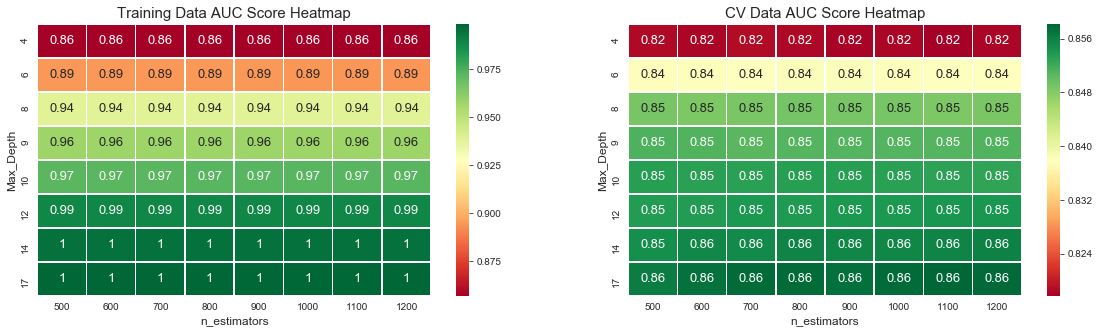

Time Consumed to Complete  Hyperparameter tuning for Simple CV Search for Random Forest Classifier on Avg W2V Vectorizer (in minutes): 55.4889896829923


In [102]:
import time
start = time.time()

AW2V_Train_df = RFTrain_Heatmap(sent_vectors_train,Y_RFTrain)
AW2V_CV_df = RFCV_Heatmap(sent_vectors_train,Y_RFTrain,sent_vectors_cv,Y_RFCV)
rf_plotheatmaps(AW2V_Train_df,AW2V_CV_df)

end = time.time()
print("Time Consumed to Complete  Hyperparameter tuning for Simple CV Search for Random Forest Classifier on "
      "Avg W2V Vectorizer (in minutes):", (end - start)/60)

With the Seaborn Heatmaps obtained, we see that :
* The maximum AUC Value on the CV Heatmap is 0.85, and the minimum AUC Value on the Train Heatmap for the same combination is 0.94. 
* Therefore the Best Combination of Max_Depth and n_estimators for the Avg W2V Featurization is either of the following: 

Max_Depth = 8.
n_estimators = 1100 or 1200.

* Therefore the best of these values is obtained by GridSearchCV below.

In [104]:
warnings.filterwarnings('ignore')

start = time.time()

#Carrying out 3-fold Cross Validation. class_weight is taken as 'balanced' since the data that we originally had
#was an Imbalanced Real World Dataset.

parameters= [{'max_depth':depth_hyperparameter,'n_estimators':estimators_hyperparameter}]
model3 = RandomForestClassifier(criterion='gini',class_weight='balanced',min_samples_split=2,
                               bootstrap=True,n_jobs=-1)
    
RF_AW2V = GridSearchCV(model3,parameters,scoring='roc_auc',cv=3)
RF_AW2V.fit(sent_vectors_train,Y_RFTrain)
    
print(RF_AW2V.best_estimator_)

end = time.time()
print("Time Consumed to Complete  Hyperparameter tuning for GridSearchCV for Random Forest Classifier on "
      "Avg W2V (in minutes):", (end - start)/60)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=17, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
Time Consumed to Complete  Hyperparameter tuning for GridSearchCV for Random Forest Classifier on Avg W2V (in minutes): 58.23843389749527


# Testing with the Test Data on the Avg W2V Representation:-

In [105]:
RFAW2V_Test = RandomForestClassifier(criterion='gini',class_weight='balanced',min_samples_split=2,max_depth=17,
                                  n_estimators=1100,bootstrap=True,n_jobs=-1)
RFAW2V_Test.fit(sent_vectors_train,Y_RFTrain)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=17, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

Therefore here we are basically creating a model (to Test the model on the Test Data) by applying the Best values of the Hyperparameters hence obtained.

In [106]:
Y_RFTrain.shape

(17500,)

In [107]:
print(sent_vectors_train.shape)

(17500, 50)


In [108]:
print(Y_RFTest.shape)

(5000,)


In [109]:
print(sent_vectors_test.shape)

(5000, 50)


In [110]:
from sklearn.metrics import roc_curve, auc 

train_fpr3,train_tpr3,threshold = roc_curve(Y_RFTrain,RFAW2V_Test.predict_proba(sent_vectors_train)[:,1])
test_fpr3,test_tpr3,threshold = roc_curve(Y_RFTest,RFAW2V_Test.predict_proba(sent_vectors_test)[:,1])

Plotting the graph between the FPR Values as well as the TPR values for the Training Data as well as the Test data
we obtain the ROC Curve as follows:

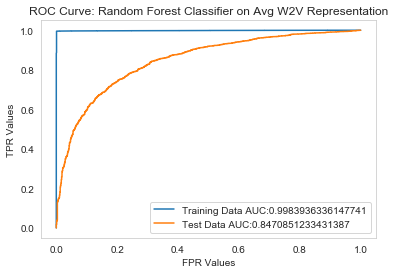

In [111]:
import matplotlib.pyplot as plt

plt.plot(train_fpr3,train_tpr3,label ='Training Data AUC:' + str(auc(train_fpr3,train_tpr3)))
plt.plot(test_fpr3,test_tpr3,label = 'Test Data AUC:' + str(auc(test_fpr3,test_tpr3)))
plt.legend()

plt.xlabel('FPR Values')
plt.ylabel('TPR Values')
plt.title('ROC Curve: Random Forest Classifier on Avg W2V Representation')

plt.grid(False)
plt.show()

# [5.1.6] SET 4 : Applying Random Forest on TFIDF W2V :-

In [113]:
model_RF = TfidfVectorizer()
tf_idf_matrix = model_RF.fit_transform(X_RFTrain)

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model_RF.get_feature_names(), list(model_RF.idf_)))

In [114]:
tf_idf_matrix.shape

(17500, 25012)

So basically tf_idf_matrix has learnt the vocabulary from X_Train and now we will apply the same on the Cross 
Validation as well as the Test Datasets.

# Converting Reviews into Numerical Vectors using W2V vectors :-

# Converting the Train Data Text :-

In [115]:
# TF-IDF weighted Word2Vec
tfidf_feat = model_RF.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_RFTrain = []; # the tfidf-w2v for each sentence/review from Training Data is stored in this list
row=0;
for sent in tqdm(list_of_sentence_Train): # for each review/sentence in Training Data
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_RFTrain.append(sent_vec)
    row += 1

100%|██████████| 17500/17500 [04:13<00:00, 68.92it/s]


In [145]:
tfidf_sent_vectors_RFTrain[1]

array([ 1.50340217e-01,  1.67166102e-01, -1.36324296e-01, -1.45961334e-01,
        1.33451191e-01,  1.46271763e-01, -3.14017693e-01, -1.66337759e-01,
        1.08598946e-01,  1.64667070e-01, -6.83528019e-02,  3.76364205e-01,
       -1.75530195e-02, -7.73021945e-02, -1.04195482e-01,  1.45072052e-01,
       -3.70068218e-01, -2.56753776e-02, -1.38101259e-01,  8.62671427e-02,
        6.30486291e-01, -3.40259556e-01,  2.62683839e-01, -4.64388854e-02,
        2.72424853e-01,  1.51372210e-01,  2.18428982e-01,  2.50856343e-01,
       -2.71302702e-01,  4.54214941e-04,  1.00237904e-01, -2.84866885e-01,
       -4.75550058e-02,  3.39206583e-01, -2.91306050e-01, -1.61539500e-01,
       -2.68240473e-01, -1.11235975e-02, -4.65053555e-01,  1.70462975e-01,
        4.72143572e-01, -1.23850753e-02,  4.22083580e-02,  3.93972935e-01,
        1.53733760e-01,  3.13323776e-01, -3.27377919e-01,  1.16299442e-02,
        4.32776899e-02, -2.16505219e-01])

# Converting the CV Data Text :-

In [117]:
# TF-IDF weighted Word2Vec
tfidf_feat = model_RF.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_RFCV = []; # the tfidf-w2v for each sentence/review from the CV Dataset is stored in this list
row=0;
for sent in tqdm(list_of_sentence_CV): # for each review/sentence in the Cross Validation Dataset 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_RFCV.append(sent_vec)
    row += 1

100%|██████████| 2500/2500 [00:44<00:00, 56.66it/s]


# Converting the Test Data Text :-

In [118]:
# TF-IDF weighted Word2Vec
tfidf_feat = model_RF.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_RFTest = []; # the tfidf-w2v for each sentence/review from the Test Dataset is stored in this list
row=0;
for sent in tqdm(list_of_sentence_Test): # for each review/sentence in the Test Dataset 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_RFTest.append(sent_vec)
    row += 1

100%|██████████| 5000/5000 [01:19<00:00, 62.59it/s]


# Hyperparameter Tuning on the TFIDF W2V Representation :- 

Random Forests are made up of Decision Trees (of large depth) as the base learners and since for Decision Trees there was no need to carry out Standardization because we did not have any hyperplane in consideration, there is no need to carry out Standardization for Random Forests as well. 

<b> <font color="black"> Calling the Different Functions to obtain the Train and CV Dataframes and Obtaining the Seaborn HeatMaps for them :- </font> </b>

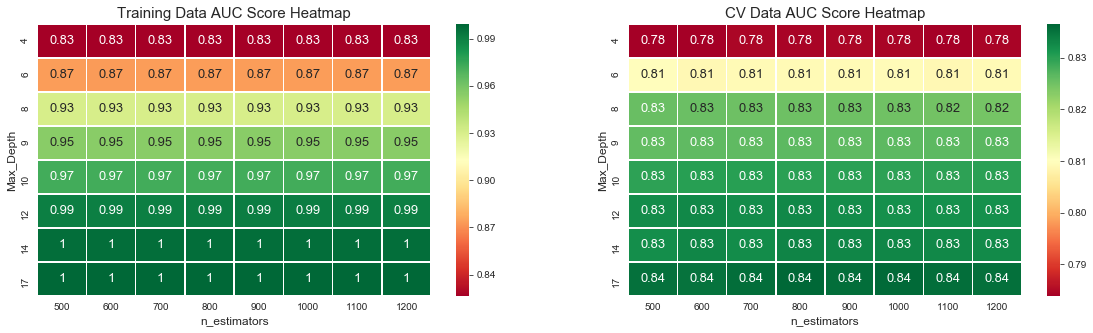

Time Consumed to Complete  Hyperparameter tuning for Simple CV Search for Random Forest Classifier on TFIDF W2V (in minutes): 64.98940306504568


In [119]:
start = time.time()

TFIDFW2V_Train_df = RFTrain_Heatmap(tfidf_sent_vectors_RFTrain,Y_RFTrain)
TFIDFW2V_CV_df = RFCV_Heatmap(tfidf_sent_vectors_RFTrain,Y_RFTrain,tfidf_sent_vectors_RFCV,Y_RFCV)
rf_plotheatmaps(TFIDFW2V_Train_df,TFIDFW2V_CV_df)

end = time.time()
print("Time Consumed to Complete  Hyperparameter tuning for Simple CV Search for Random Forest Classifier on "
      "TFIDF W2V (in minutes):", (end - start)/60)

With the Seaborn Heatmaps obtained, we see that :
* The maximum AUC Value on the CV Heatmap is 0.84, and the minimum AUC Value on the Train Heatmap for the same combination is 1.00. 
* Therefore the Best Combination of Max_Depth and n_estimators for the TFIDF W2V Featurization is either of the following: 

Max_Depth = 14 or 17.
n_estimators = 1100 or 1200.

* Therefore the best of these values is obtained by GridSearchCV below.

In [121]:
warnings.filterwarnings('ignore')

start = time.time()

#Carrying out 3-fold Cross Validation. class_weight is taken as 'balanced' since the data that we originally had
#was an Imbalanced Real World Dataset.

parameters= [{'max_depth':depth_hyperparameter,'n_estimators':estimators_hyperparameter}]
model4 = RandomForestClassifier(criterion='gini',class_weight='balanced',min_samples_split=2,
                               bootstrap=True,n_jobs=-1)
    
RF_TFIDFW2V = GridSearchCV(model4,parameters,scoring='roc_auc',cv=3)
RF_TFIDFW2V.fit(tfidf_sent_vectors_RFTrain,Y_RFTrain)
    
print(RF_TFIDFW2V.best_estimator_)

end = time.time()
print(" ")
print("Time Consumed to Complete  Hyperparameter tuning for GridSearchCV for Random Forest Classifier on "
      "TFIDF W2V (in minutes):", (end - start)/60)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=17, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
 
Time Consumed to Complete  Hyperparameter tuning for GridSearchCV for Random Forest Classifier on TFIDF W2V (in minutes): 58.08252164920171


# Testing with the Test Data on the TFIDF W2V Representation:-

In [122]:
RFTFIDFW2V_Test = RandomForestClassifier(criterion='gini',class_weight='balanced',min_samples_split=2,max_depth=17,
                                  n_estimators=1100,bootstrap=True,n_jobs=-1)
RFTFIDFW2V_Test.fit(tfidf_sent_vectors_RFTrain,Y_RFTrain)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=17, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

Therefore here we are basically creating a model (to Test the model on the Test Data) by applying the Best values of the Hyperparameters hence obtained.

In [123]:
from sklearn.metrics import roc_curve, auc 

train_fpr4,train_tpr4,threshold = roc_curve(Y_RFTrain,RFTFIDFW2V_Test.predict_proba(tfidf_sent_vectors_RFTrain)[:,1])
test_fpr4,test_tpr4,threshold = roc_curve(Y_RFTest,RFTFIDFW2V_Test.predict_proba(tfidf_sent_vectors_RFTest)[:,1])

Plotting the graph between the FPR Values as well as the TPR values for the Training Data as well as the Test data
we obtain the ROC Curve as follows:

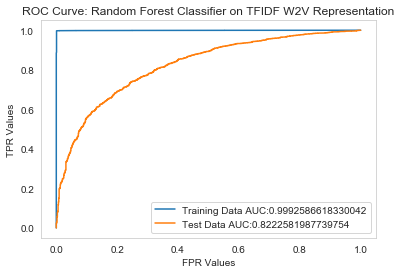

In [124]:
import matplotlib.pyplot as plt

plt.plot(train_fpr4,train_tpr4,label ='Training Data AUC:' + str(auc(train_fpr4,train_tpr4)))
plt.plot(test_fpr4,test_tpr4,label = 'Test Data AUC:' + str(auc(test_fpr4,test_tpr4)))
plt.legend()

plt.xlabel('FPR Values')
plt.ylabel('TPR Values')
plt.title('ROC Curve: Random Forest Classifier on TFIDF W2V Representation')

plt.grid(False)
plt.show()

# [5.2] Applying GBDT using XGBOOST :-

# [5.2.1] SET 1 : Applying XGBOOST on BOW Vectorization :-

# Hyperparameter Tuning on the BOW Representation using XGBOOST :- 

In [125]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import roc_auc_score

In [126]:
GBDT_depth_hyperparameter = [2, 3, 4, 5, 6, 7, 8, 9, 10]
GBDT_estimators_hyperparameter = [5, 10, 50, 100, 200, 500, 1000]

<b> <font color="black"> Function to obtain the DataFrame for the AUC Metric Calculation using XGBOOST from the Training Data  :- </font> </b>

In [127]:
def GBDTTrain_Heatmap(X_Train,Y_Train):

    df5 = []
    df6 = []
    Train_AUC_XGB = []

    for i in GBDT_depth_hyperparameter:
        for j in GBDT_estimators_hyperparameter:
            df5.append(i)
            df6.append(j)
            
            Train_model = XGBClassifier(max_depth=i,subsample=0.7,colsample_bytree=0.7,eval_metric='auc',
                                        n_estimators=j,learning_rate=0.1,booster='gbtree')
            Train_model.fit(X_Train,Y_Train)
            
            Y_Train_XGB_pred = Train_model.predict_proba(X_Train)[:,1]
            Train_AUC_XGB.append(roc_auc_score(Y_Train,Y_Train_XGB_pred))  
            
    train_data_XGB = {'max_depth':df5,'n_estimators':df6,'AUC_Score':Train_AUC_XGB}
    train_dataframe_XGB = pd.DataFrame(train_data_XGB)
    train_dataframe_XGB = train_dataframe_XGB.pivot("max_depth","n_estimators","AUC_Score")
            
    return train_dataframe_XGB          

<b> <font color="black"> Function to obtain the DataFrame for the AUC Metric Calculation using XGBOOST from the CV Data  :- </font> </b>

In [128]:
def GBDTCV_Heatmap(X_Train,Y_Train,X_CV,Y_CV):

    df7 = []
    df8 = []
    CV_AUC_XGB = []

    for i in GBDT_depth_hyperparameter:
        for j in GBDT_estimators_hyperparameter:
            df7.append(i)
            df8.append(j)
           
            Train_model = XGBClassifier(max_depth=i,subsample=0.7,colsample_bytree=0.7,eval_metric='auc',
                                        n_estimators=j,learning_rate=0.1,booster='gbtree')
            Train_model.fit(X_Train,Y_Train)
        
            Y_CV_XGB_pred = Train_model.predict_proba(X_CV)[:,1]
            CV_AUC_XGB.append(roc_auc_score(Y_CV,Y_CV_XGB_pred))   
            
    cv_data_XGB = {'max_depth':df7,'n_estimators':df8,'AUC_Score':CV_AUC_XGB}
    cv_dataframe_XGB = pd.DataFrame(cv_data_XGB)
    cv_dataframe_XGB = cv_dataframe_XGB.pivot("max_depth","n_estimators","AUC_Score")
            
    return cv_dataframe_XGB            

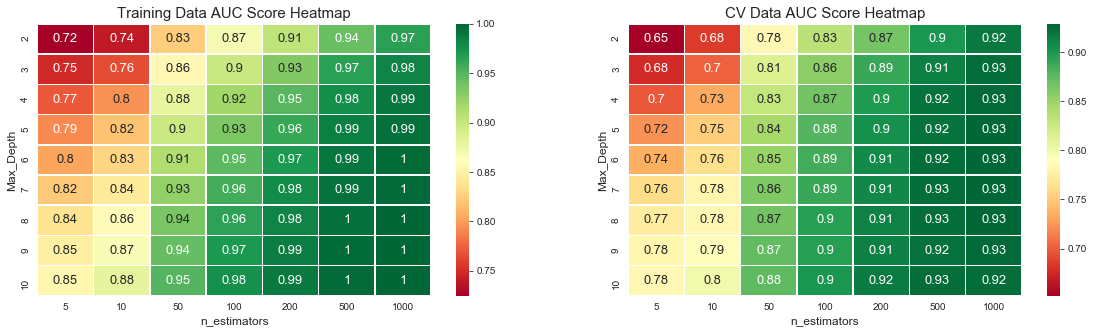

Time Consumed to Complete  Hyperparameter tuning for GBDT(XGBoost Implementation) Grid Search on BOW Vectorizer in minutes 177.28791013558705


In [130]:
import time
start = time.time()

GBDTBOW_Train_df = GBDTTrain_Heatmap(X_RFTrain_BOW,Y_RFTrain)
GBDTBOW_CV_df = GBDTCV_Heatmap(X_RFTrain_BOW,Y_RFTrain,X_RFCV_BOW,Y_RFCV)
rf_plotheatmaps(GBDTBOW_Train_df,GBDTBOW_CV_df)

end = time.time()
print("Time Consumed to Complete  Hyperparameter tuning for GBDT(XGBoost Implementation) Grid Search on"
      " BOW Vectorizer in minutes :",(end - start)/60)

With the Seaborn Heatmaps obtained, we see that :
* The maximum AUC Value on the CV Heatmap is 0.93, and the minimum AUC Value on the Train Heatmap for the same combination is 0.98. 
* Therefore the Best Combination of Max_Depth and n_estimators for the BOW Featurization is the following: 

Max_Depth = 3.
n_estimators= 1000.

# Testing with the Test Data on the BOW Representation:-

In [156]:
GBDTBOW_Test = XGBClassifier(max_depth=3,subsample=0.7,colsample_bytree=0.7,eval_metric='auc',
                                        n_estimators=1000,learning_rate=0.1,booster='gbtree')
GBDTBOW_Test.fit(X_RFTrain_BOW,Y_RFTrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.7, eval_metric='auc',
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.7, verbosity=1)

Therefore here we are basically creating a model (to Test the model on the Test Data) by applying the Best values of the Hyperparameters hence obtained.

In [157]:
from sklearn.metrics import roc_curve, auc 

train_fpr5,train_tpr5,threshold = roc_curve(Y_RFTrain,GBDTBOW_Test.predict_proba(X_RFTrain_BOW)[:,1])
test_fpr5,test_tpr5,threshold = roc_curve(Y_RFTest,GBDTBOW_Test.predict_proba(X_RFTest_BOW)[:,1])

Plotting the graph between the FPR Values as well as the TPR values for the Training Data as well as the Test data
we obtain the ROC Curve as follows:

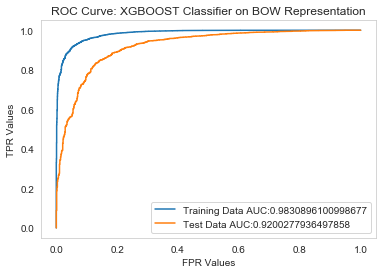

In [158]:
import matplotlib.pyplot as plt

plt.plot(train_fpr5,train_tpr5,label ='Training Data AUC:' + str(auc(train_fpr5,train_tpr5)))
plt.plot(test_fpr5,test_tpr5,label = 'Test Data AUC:' + str(auc(test_fpr5,test_tpr5)))
plt.legend()

plt.xlabel('FPR Values')
plt.ylabel('TPR Values')
plt.title('ROC Curve: XGBOOST Classifier on BOW Representation')

plt.grid(False)
plt.show()

# [5.2.2] SET 2 : Applying XGBOOST on TFIDF Vectorization :-

# Hyperparameter Tuning on the TFIDF Representation using XGBOOST :- 

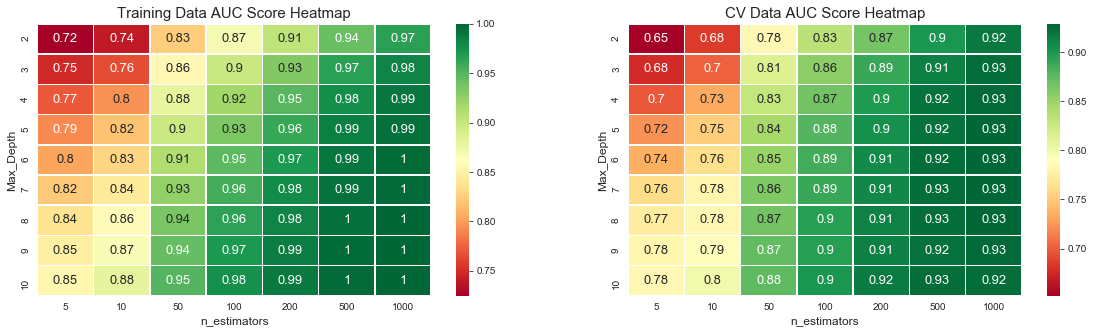

Time Consumed to Complete Hyperparameter tuning for GBDT(XGBoost Implementation) Simple CV on TFIDF Vectorizer in minutes : 178.60421149730684


In [134]:
import time
start = time.time()

GBDTTFIDF_Train_df = GBDTTrain_Heatmap(X_RFTrain_TFIDF,Y_RFTrain)
GBDTTFIDF_CV_df = GBDTCV_Heatmap(X_RFTrain_TFIDF,Y_RFTrain,X_RFCV_TFIDF,Y_RFCV)
rf_plotheatmaps(GBDTBOW_Train_df,GBDTBOW_CV_df)

end = time.time()
print("Time Consumed to Complete Hyperparameter tuning for GBDT(XGBoost Implementation) Simple CV on"
      " TFIDF Vectorizer in minutes :",(end - start)/60)

With the Seaborn Heatmaps obtained, we see that :
* The maximum AUC Value on the CV Heatmap is 0.93, and the minimum AUC Value on the Train Heatmap for the same combination is 0.98. 
* Therefore the Best Combination of Max_Depth and n_estimators for the TFIDF Featurization is the following: 

Max_Depth=3.
n_estimators= 1000.

# Testing with the Test Data on the TFIDF Representation:-

In [135]:
GBDTTFIDF_Test = XGBClassifier(max_depth=3,subsample=0.7,colsample_bytree=0.7,eval_metric='auc',
                                        n_estimators=1000,learning_rate=0.1,booster='gbtree')
GBDTTFIDF_Test.fit(X_RFTrain_TFIDF,Y_RFTrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.7, eval_metric='auc',
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.7, verbosity=1)

Therefore here we are basically creating a model (to Test the model on the Test Data) by applying the Best values of the Hyperparameters hence obtained.

In [136]:
from sklearn.metrics import roc_curve, auc 

train_fpr6,train_tpr6,threshold = roc_curve(Y_RFTrain,GBDTTFIDF_Test.predict_proba(X_RFTrain_TFIDF)[:,1])
test_fpr6,test_tpr6,threshold = roc_curve(Y_RFTest,GBDTTFIDF_Test.predict_proba(X_RFTest_TFIDF)[:,1])

Plotting the graph between the FPR Values as well as the TPR values for the Training Data as well as the Test data
we obtain the ROC Curve as follows:

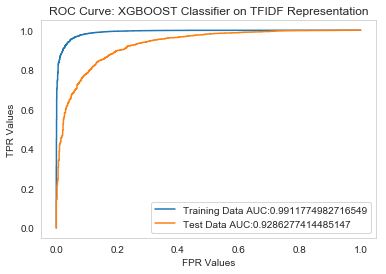

In [137]:
import matplotlib.pyplot as plt

plt.plot(train_fpr6,train_tpr6,label ='Training Data AUC:' + str(auc(train_fpr6,train_tpr6)))
plt.plot(test_fpr6,test_tpr6,label = 'Test Data AUC:' + str(auc(test_fpr6,test_tpr6)))
plt.legend()

plt.xlabel('FPR Values')
plt.ylabel('TPR Values')
plt.title('ROC Curve: XGBOOST Classifier on TFIDF Representation')

plt.grid(False)
plt.show()

# [5.2.3] SET 3 : Applying XGBOOST on Avg W2V Vectorization :-

# Hyperparameter Tuning on the Avg W2V Representation using XGBOOST :- 

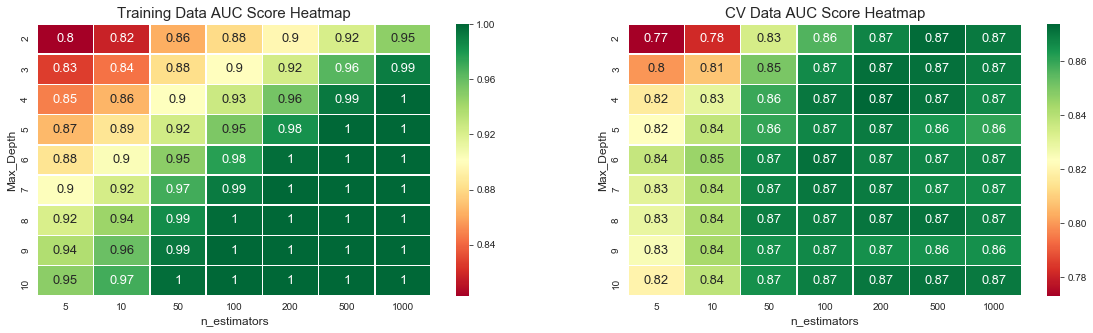

Time Consumed to Complete Hyperparameter tuning for GBDT(XGBoost Implementation) Simple CV on Avg W2V in minutes : 59.18065168857574


In [138]:
import time
start = time.time()

GBDTAW2V_Train_df = GBDTTrain_Heatmap(sent_vectors_train,Y_RFTrain)
GBDTAW2V_CV_df = GBDTCV_Heatmap(sent_vectors_train,Y_RFTrain,sent_vectors_cv,Y_RFCV)
rf_plotheatmaps(GBDTAW2V_Train_df,GBDTAW2V_CV_df)

end = time.time()
print("Time Consumed to Complete Hyperparameter tuning for GBDT(XGBoost Implementation) Simple CV on"
      " Avg W2V in minutes :",(end - start)/60)

With the Seaborn Heatmaps obtained, we see that :
* The maximum AUC Value on the CV Heatmap is 0.87, and the minimum AUC Value on the Train Heatmap for the same combination is 0.90. 
* Therefore the Best Combination of Max_Depth and n_estimators for the Avg W2V Featurization is either of the following: 

Max_Depth = 2.
n_estimators = 200 .

# Testing with the Test Data on the Avg W2V Representation:-

In [159]:
GBDTAW2V_Test = XGBClassifier(max_depth=2,subsample=0.7,colsample_bytree=0.7,eval_metric='auc',
                                        n_estimators=200,learning_rate=0.1,booster='gbtree')
GBDTAW2V_Test.fit(sent_vectors_train,Y_RFTrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.7, eval_metric='auc',
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.7, verbosity=1)

Therefore here we are basically creating a model (to Test the model on the Test Data) by applying the Best values of the Hyperparameters hence obtained.

In [160]:
from sklearn.metrics import roc_curve, auc 

train_fpr7,train_tpr7,threshold = roc_curve(Y_RFTrain,GBDTAW2V_Test.predict_proba(sent_vectors_train)[:,1])
test_fpr7,test_tpr7,threshold = roc_curve(Y_RFTest,GBDTAW2V_Test.predict_proba(sent_vectors_test)[:,1])

Plotting the graph between the FPR Values as well as the TPR values for the Training Data as well as the Test data
we obtain the ROC Curve as follows:

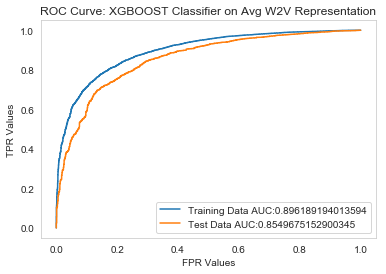

In [161]:
import matplotlib.pyplot as plt

plt.plot(train_fpr7,train_tpr7,label ='Training Data AUC:' + str(auc(train_fpr7,train_tpr7)))
plt.plot(test_fpr7,test_tpr7,label = 'Test Data AUC:' + str(auc(test_fpr7,test_tpr7)))
plt.legend()

plt.xlabel('FPR Values')
plt.ylabel('TPR Values')
plt.title('ROC Curve: XGBOOST Classifier on Avg W2V Representation')

plt.grid(False)
plt.show()

# [5.2.4] SET 4 : Applying XGBOOST on TFIDF W2V Vectorization :-

# Hyperparameter Tuning on the TFIDF W2V Representation using XGBOOST :- 

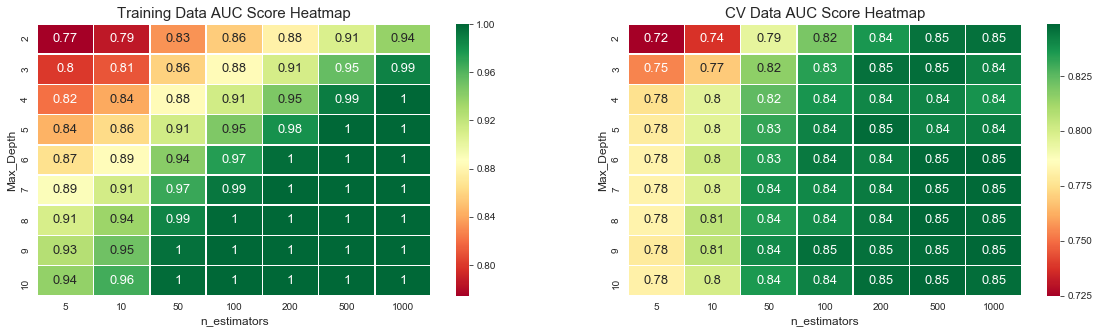

Time Consumed to Complete Hyperparameter tuning for GBDT(XGBoost Implementation) Simple CV on TFIDF W2V in minutes : 61.93146287202835


In [151]:
import time
start = time.time()

GBDTTFIDFW2V_Train_df = GBDTTrain_Heatmap(np.array(tfidf_sent_vectors_RFTrain),Y_RFTrain)
#We need to convert the X_Train to a numpy array because otherwise we get an error that says:- "List has no attribute"
#called shape

GBDTTFIDFW2V_CV_df = GBDTCV_Heatmap(np.array(tfidf_sent_vectors_RFTrain),Y_RFTrain,tfidf_sent_vectors_RFCV,Y_RFCV)
rf_plotheatmaps(GBDTTFIDFW2V_Train_df,GBDTTFIDFW2V_CV_df)

end = time.time()
print("Time Consumed to Complete Hyperparameter tuning for GBDT(XGBoost Implementation) Simple CV on"
      " TFIDF W2V in minutes :",(end - start)/60)

With the Seaborn Heatmaps obtained, we see that :
* The maximum AUC Value on the CV Heatmap is 0.85, and the minimum AUC Value on the Train Heatmap for the same combination is 0.91. 
* Therefore the Best Combination of Max_Depth and Min_samples_split for the BOW Featurization is either of the following: 

Max_Depth=2.
n_estimators= 500.

# Testing with the Test Data on the TFIDF W2V Representation:-

In [153]:
GBDTTFIDFW2V_Test = XGBClassifier(max_depth=2,subsample=0.7,colsample_bytree=0.7,eval_metric='auc',
                                        n_estimators=500,learning_rate=0.1,booster='gbtree')
GBDTTFIDFW2V_Test.fit(np.array(tfidf_sent_vectors_RFTrain),Y_RFTrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.7, eval_metric='auc',
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.7, verbosity=1)

Therefore here we are basically creating a model (to Test the model on the Test Data) by applying the Best values of the Hyperparameters hence obtained.

In [154]:
from sklearn.metrics import roc_curve, auc 

train_fpr8,train_tpr8,threshold = roc_curve(Y_RFTrain,GBDTTFIDFW2V_Test.predict_proba(tfidf_sent_vectors_RFTrain)[:,1])
test_fpr8,test_tpr8,threshold = roc_curve(Y_RFTest,GBDTTFIDFW2V_Test.predict_proba(tfidf_sent_vectors_RFTest)[:,1])

Plotting the graph between the FPR Values as well as the TPR values for the Training Data as well as the Test data
we obtain the ROC Curve as follows:

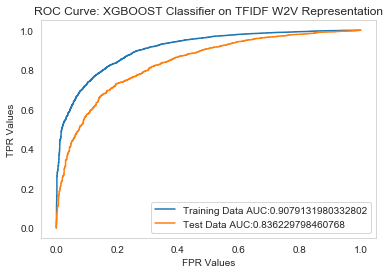

In [155]:
import matplotlib.pyplot as plt

plt.plot(train_fpr8,train_tpr8,label ='Training Data AUC:' + str(auc(train_fpr8,train_tpr8)))
plt.plot(test_fpr8,test_tpr8,label = 'Test Data AUC:' + str(auc(test_fpr8,test_tpr8)))
plt.legend()

plt.xlabel('FPR Values')
plt.ylabel('TPR Values')
plt.title('ROC Curve: XGBOOST Classifier on TFIDF W2V Representation')

plt.grid(False)
plt.show()

# [6] Conclusions

In [241]:
from prettytable import PrettyTable

a=PrettyTable()
a.field_names=["S No.","Top 20 Important Features","Weight"]

In [242]:
print("Top 20 Most Important Features with Random Forest Ensembling & BOW Featurization:")
print(" "*100)

a.add_row(["1","not","0.037"])
a.add_row(["2","great","0.022"])
a.add_row(["3","best","0.015"])
a.add_row(["4","would","0.015"])
a.add_row(["5","perfect","0.014"])
a.add_row(["6","love","0.013"])
a.add_row(["7","horrible","0.012"])
a.add_row(["8","delicious","0.012"])
a.add_row(["9","disappointed","0.012"])
a.add_row(["10","bad","0.011"])
a.add_row(["11","money","0.011"])
a.add_row(["12","worst","0.01"])
a.add_row(["13","thought","0.008"])
a.add_row(["14","highly","0.008"])
a.add_row(["15","easy","0.008"])
a.add_row(["16","wonderful","0.007"])
a.add_row(["17","favorite","0.007"])
a.add_row(["18","terrible","0.007"])
a.add_row(["19","snack","0.007"])
a.add_row(["20","product","0.007"])

print(a)

Top 20 Most Important Features with Random Forest Ensembling & BOW Featurization:
                                                                                                    
+-------+---------------------------+--------+
| S No. | Top 20 Important Features | Weight |
+-------+---------------------------+--------+
|   1   |            not            | 0.037  |
|   2   |           great           | 0.022  |
|   3   |            best           | 0.015  |
|   4   |           would           | 0.015  |
|   5   |          perfect          | 0.014  |
|   6   |            love           | 0.013  |
|   7   |          horrible         | 0.012  |
|   8   |         delicious         | 0.012  |
|   9   |        disappointed       | 0.012  |
|   10  |            bad            | 0.011  |
|   11  |           money           | 0.011  |
|   12  |           worst           |  0.01  |
|   13  |          thought          | 0.008  |
|   14  |           highly          | 0.008  |
|   15  |         

In [243]:
b=PrettyTable()
b.field_names=["S No.","Top 20 Important Features","Weight"]

In [244]:
print("Top 20 Most Important Features with Random Forest Ensembling & TFIDF Featurization:")
print(" "*100)

b.add_row(["1","not","0.037"])
b.add_row(["2","great","0.029"])
b.add_row(["3","best","0.017"])
b.add_row(["4","would","0.017"])
b.add_row(["5","love","0.016"])
b.add_row(["6","delicious","0.014"])
b.add_row(["7","bad","0.013"])
b.add_row(["8","disappointed","0.013"])
b.add_row(["9","perfect","0.012"])
b.add_row(["10","would not","0.011"])
b.add_row(["11","worst","0.011"])
b.add_row(["12","money","0.01"])
b.add_row(["13","thought","0.009"])
b.add_row(["14","good","0.009"])
b.add_row(["15","not buy","0.009"])
b.add_row(["16","favorite","0.008"])
b.add_row(["17","loves","0.008"])
b.add_row(["18","easy","0.008"])
b.add_row(["19","horrible","0.008"])
b.add_row(["20","away","0.007"])

print(b)

Top 20 Most Important Features with Random Forest Ensembling & TFIDF Featurization:
                                                                                                    
+-------+---------------------------+--------+
| S No. | Top 20 Important Features | Weight |
+-------+---------------------------+--------+
|   1   |            not            | 0.037  |
|   2   |           great           | 0.029  |
|   3   |            best           | 0.017  |
|   4   |           would           | 0.017  |
|   5   |            love           | 0.016  |
|   6   |         delicious         | 0.014  |
|   7   |            bad            | 0.013  |
|   8   |        disappointed       | 0.013  |
|   9   |          perfect          | 0.012  |
|   10  |         would not         | 0.011  |
|   11  |           worst           | 0.011  |
|   12  |           money           |  0.01  |
|   13  |          thought          | 0.009  |
|   14  |            good           | 0.009  |
|   15  |       

In [245]:
c = PrettyTable()
c.field_names=["Ensemble","Model","Ideal Max_Depth","Ideal n_estimators","Test AUC Score"]

In [246]:
print("Performance on Test Data using different Featurizations using Decision Trees:")
print(" "*100)

c.add_row(["Random Forest","BOW","12","1100","0.91"])
c.add_row(["Random Forest","TFIDF","17","1100","0.91"])
c.add_row(["Random Forest","Avg W2V","17","1100","0.84"])
c.add_row(["Random Forest","TFIDF W2V","17","1100","0.82"])
c.add_row(["XGBoost","BOW","3","1000","0.92"])
c.add_row(["XGBoost","TFIDF","3","1000","0.93"])
c.add_row(["XGBoost","Avg W2V","2","200","0.85"])
c.add_row(["XGBoost","TFIDF W2V","2","500","0.84"])

print(c)

Performance on Test Data using different Featurizations using Decision Trees:
                                                                                                    
+---------------+-----------+-----------------+--------------------+----------------+
|    Ensemble   |   Model   | Ideal Max_Depth | Ideal n_estimators | Test AUC Score |
+---------------+-----------+-----------------+--------------------+----------------+
| Random Forest |    BOW    |        12       |        1100        |      0.91      |
| Random Forest |   TFIDF   |        17       |        1100        |      0.91      |
| Random Forest |  Avg W2V  |        17       |        1100        |      0.84      |
| Random Forest | TFIDF W2V |        17       |        1100        |      0.82      |
|    XGBoost    |    BOW    |        3        |        1000        |      0.92      |
|    XGBoost    |   TFIDF   |        3        |        1000        |      0.93      |
|    XGBoost    |  Avg W2V  |        2        |

<b> <font color="black"> Following are some Conclusions from the observations:- </font> </b>

* As far as the "Random Forest Ensemble" performance for the different featurizations is concerned, both BOW & TFIDF are the best across all the models since it has the highest Test AUC.
* As far as the "XGBoost Ensemble" performance for the different featurizations is concerned TFIDF are the best across all the models since it has the highest Test AUC of 0.93.
* Overall, when you compare the 2 Ensembles (ie Bagging & Boosting) in this scenario, TFIDF is the Best Algorithm with the Highest Test AUC Score of 0.93. 

Note :- We have not computed the Accuracy on the Test Data here because our Dataset is Highly imbalanced and it makes no sense to obtain the Confusion Matrices & find the Test Accuracy. Instead ROC is a good metric where our Test AUC is not impacted by the Imbalanced data. 